In [48]:
import numpy as np
import torch

# import torch.distributions.constraints as constraints
# import torch.distributions as tdist
import pyro
import pyro.infer
import pyro.optim
import pyro.distributions as dist
from pyro.infer.autoguide import AutoNormal

# import matplotlib.pyplot as plt
# from tqdm import tqdm
import pickle as pkl

pyro.set_rng_seed(101)


In [49]:
data = pkl.load(
    open("/data/pinello/PROJECTS/2022_PPIseq/data/1028/1028_pyro_dict.pkl", "rb")
)
print(data.keys())


dict_keys(['reads_edited', 'reads_unedited', 'size_factors', 'fit_dispersions', 'q_design_matrix', 'pi_design_matrix'])


 data contains:
 - reads_edited, shape: [len(experiments), len(orfs)]

 - reads_unedited, shape: [len(experiments), len(orfs)]

 - size_factors, shape: [len(experiments), ]

 - fit_dispersions, shape: [len(experiments), ]

 - q_design_matrix, shape: [len(experiments), len(betas_q)]

 - pi_design_matrix, shape: [len(experiments), len(betas_pi)]

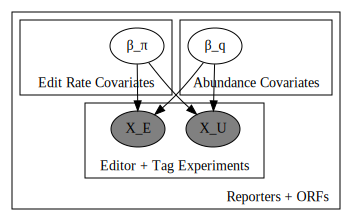

In [78]:
def ppiseq_model(data):  # sourcery skip: extract-method
    n_exps, n_orfs = data["reads_edited"].shape
    n_q_covs = data["q_design_matrix"].shape[1]
    n_pi_covs = data["pi_design_matrix"].shape[1]

    # dispersion_var=1

    with pyro.plate("Reporters + ORFs", n_orfs):
        with pyro.plate("Abundance Covariates", n_q_covs):
            betas_q = pyro.sample("β_q", dist.Normal(0, 1))

        with pyro.plate("Edit Rate Covariates", n_pi_covs):
            betas_pi = pyro.sample("β_π", dist.Normal(0, 1))

        with pyro.plate("Editor + Tag Experiments", n_exps):
            # TODO dispersion sampling possibly
            # dispersion = pyro.sample(
            #     "φ", dist.LogNormal(data["fit_dispersions"].log(), dispersion_var)
            # )

            log_q = data["q_design_matrix"].float() @ betas_q
            # * this needs to be a bit more convincing to me
            pi = (data["pi_design_matrix"].float() @ betas_pi).sigmoid()

            logits_U = (
                log_q
                + -pi.logit()
                + data["size_factors"].log()
                - data["fit_dispersions"].log()
            )
            logits_E = (
                log_q
                + pi.logit()
                + data["size_factors"].log()
                - data["fit_dispersions"].log()
            )

            dist_U = dist.NegativeBinomial(data["fit_dispersions"], logits=logits_U)
            dist_E = dist.NegativeBinomial(data["fit_dispersions"], logits=logits_E)

            pyro.sample("X_U", dist_U, obs=data["reads_unedited"])
            pyro.sample("X_E", dist_E, obs=data["reads_edited"])


pyro.render_model(ppiseq_model, model_args=(data,), render_params=True)


In [79]:
guide = AutoNormal(ppiseq_model, init_scale=0.01)

pyro.clear_param_store()
initial_lr = 0.05
gamma = 0.1  # final learning rate will be gamma * initial_lr
num_steps = 2000
lrd = gamma ** (1 / num_steps)
svi = pyro.infer.SVI(
    model=ppiseq_model,
    guide=guide,
    optim=pyro.optim.ClippedAdam({"lr": initial_lr, "lrd": lrd}),
    loss=pyro.infer.Trace_ELBO(),
)


# # keep track of anything meaningful here
# beta1s, beta1_vars, beta0s, beta0_vars, dm, dv, api, bpi, pis, losses = (
#     [] for _ in range(10)
# )
# num_steps = 100
losses = [svi.step(data) for _ in range(num_steps)]
#     if t == 1:
#         print(pyro.get_param_store())
#     beta1s.append(pyro.param("AutoNormal.locs.beta_1").clone())
#     beta1_vars.append(pyro.param("AutoNormal.scales.beta_1"))
#     beta0s.append(pyro.param("AutoNormal.locs.beta_0").clone())
#     beta0_vars.append(pyro.param("AutoNormal.scales.beta_0"))
#     dm.append(pyro.param("AutoNormal.locs.dispersion").clone())
#     dv.append(pyro.param("AutoNormal.scales.dispersion"))
#     api.append(pyro.param("alpha_pi").clone().detach())
#     bpi.append(pyro.param("beta_pi").clone().detach())
#     a = pyro.param("alpha_pi").clone().detach()
#     b = pyro.param("beta_pi").clone().detach()
#     pis.append(a / (a + b))


Text(0, 0.5, 'loss')

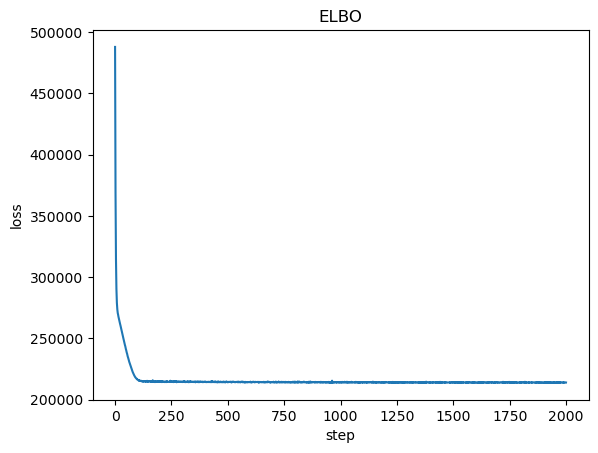

In [80]:
import matplotlib.pyplot as plt

plt.plot(losses)
plt.title("ELBO")
plt.xlabel("step")
plt.ylabel("loss")
